<a href="https://colab.research.google.com/github/stonkpab/GeoMind/blob/main/geomind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Imports


In [ ]:

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
base_dir = "/content/drive/MyDrive/GeoMind/"

Mounted at /content/drive


In [ ]:
pip install tqdm

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import json
import keras

#Initial Dataframe

In [ ]:
df = pd.read_json(base_dir + "tweets.json", lines=True)
df.head()

,id,text,geo
0,1223412331729817601,I'm buying 2 ton of #lysol and investing in Ly...,"[26.063241, -80.289742]"
1,1223663962513760257,Come to Philly Reclaim for all you're Coronavi...,"[40.01829749, -75.04340172]"
2,1223458629535371264,#Lysol #coronavirus this is the actual label f...,"[34.02686328, -84.21613127]"
3,1223607938603978753,Come on? Basta! This video is real🤬\n•\n•\n#ch...,"[26.6318, -81.8571]"
4,1223548411946758146,Vaccinate your goddamn kids!!\n\n#antivax #vac...,"[30.4959761, -81.6035962]"


In [ ]:
df.shape

(19113, 3)

#Target Data Specification


##Geo/Twitter API

In [ ]:
pip install geopy

In [ ]:
from geopy.geocoders import GoogleV3
from geopy.extra.rate_limiter import RateLimiter

In [ ]:
geolocator = GoogleV3("")

In [ ]:
pip install tweepy

In [ ]:
import tweepy

In [ ]:
auth = tweepy.AppAuthHandler("", "")
api = tweepy.API(auth)

##Full Location


In [ ]:
#geolocator.reverse(df.iloc[0,2]).raw["address"].get('state')
#use for nominatim

In [ ]:
geolocator.reverse(df.iloc[0,2],exactly_one=True).raw['address_components']

[{'long_name': '10620', 'short_name': '10620', 'types': ['street_number']},
 {'long_name': 'Griffin Road', 'short_name': 'Griffin Rd', 'types': ['route']},
 {'long_name': 'Davie',
  'short_name': 'Davie',
  'types': ['locality', 'political']},
 {'long_name': 'Broward County',
  'short_name': 'Broward County',
  'types': ['administrative_area_level_2', 'political']},
 {'long_name': 'Florida',
  'short_name': 'FL',
  'types': ['administrative_area_level_1', 'political']},
 {'long_name': 'United States',
  'short_name': 'US',
  'types': ['country', 'political']},
 {'long_name': '33328', 'short_name': '33328', 'types': ['postal_code']},
 {'long_name': '3217', 'short_name': '3217', 'types': ['postal_code_suffix']}]

In [ ]:
loc = []
for i in tqdm(range(df.shape[0])):
  try:
    loc.append(geolocator.reverse(df.iloc[i,2],exactly_one=True).raw['address_components'])
  except:
    loc.append(None)

len(loc) == df.shape[0]

Streaming output truncated to the last 5000 lines.

 76%|███████▌  | 14448/19113 [13:26<04:35, 16.93it/s]


 76%|███████▌  | 14450/19113 [13:26<04:44, 16.40it/s]


 76%|███████▌  | 14453/19113 [13:26<04:24, 17.60it/s]


 76%|███████▌  | 14456/19113 [13:26<03:58, 19.56it/s]


 76%|███████▌  | 14459/19113 [13:26<03:42, 20.93it/s]


 76%|███████▌  | 14464/19113 [13:26<03:19, 23.35it/s]


 76%|███████▌  | 14467/19113 [13:27<03:22, 22.91it/s]


 76%|███████▌  | 14470/19113 [13:27<03:40, 21.02it/s]


 76%|███████▌  | 14473/19113 [13:27<03:52, 19.95it/s]


 76%|███████▌  | 14476/19113 [13:27<03:55, 19.71it/s]


 76%|███████▌  | 14479/19113 [13:27<03:51, 20.01it/s]


 76%|███████▌  | 14482/19113 [13:28<05:05, 15.14it/s]


 76%|███████▌  | 14485/19113 [13:28<04:28, 17.21it/s]


 76%|███████▌  | 14488/19113 [13:28<03:58, 19.38it/s]


 76%|███████▌  | 14491/19113 [13:28<03:44, 20.59it/s]


 76%|███████▌  | 14494/19113 [13:28<04:04, 18.90it/s]


 76%|███████▌  | 14497/19113 [13:28<04:43, 16.29it/s

True

In [ ]:
df["loc"] = loc
df.head()

,id,text,geo,loc
0,1223412331729817601,I'm buying 2 ton of #lysol and investing in Ly...,"[26.063241, -80.289742]","[{'long_name': '10620', 'short_name': '10620',..."
1,1223663962513760257,Come to Philly Reclaim for all you're Coronavi...,"[40.01829749, -75.04340172]","[{'long_name': '6501', 'short_name': '6501', '..."
2,1223458629535371264,#Lysol #coronavirus this is the actual label f...,"[34.02686328, -84.21613127]","[{'long_name': '740', 'short_name': '740', 'ty..."
3,1223607938603978753,Come on? Basta! This video is real🤬\n•\n•\n#ch...,"[26.6318, -81.8571]","[{'long_name': '2548', 'short_name': '2548', '..."
4,1223548411946758146,Vaccinate your goddamn kids!!\n\n#antivax #vac...,"[30.4959761, -81.6035962]","[{'long_name': '816', 'short_name': '816', 'ty..."


In [ ]:
df[df['loc'].isnull()].index.tolist()

[18165]

In [ ]:
df.iloc[18165]

id                                    1255463165846065154
text    #rubyprincess #Cruise #covid-19 #sydney #trave...
geo                           [18.40221442, -65.26294415]
loc                                                  None
Name: 18165, dtype: object

In [ ]:
df = df.drop([18165], axis=0)

In [ ]:
df.to_json(base_dir + "geo_tweets.json")

## States


In [ ]:
df = pd.read_json(base_dir + "geo_tweets.json")
len(df)

19112

In [ ]:
no_states = []
for i in range(df.shape[0]):
  try:
    list(filter(lambda state: "administrative_area_level_1" in state['types'], df.iloc[i,3]))[0]["long_name"]
  except:
    no_states.append(i)

In [ ]:
df = df.drop(no_states, axis=0)

In [ ]:
df["state"] = [list(filter(lambda state: "administrative_area_level_1" in state['types'], df.iloc[i,3]))[0]["long_name"] for i in range(df.shape[0])]
df.head()

,id,text,geo,loc,state
0,1223412331729817601,I'm buying 2 ton of #lysol and investing in Ly...,"[26.063241, -80.289742]","[{'long_name': '10620', 'short_name': '10620',...",Florida
1,1223663962513760257,Come to Philly Reclaim for all you're Coronavi...,"[40.01829749, -75.04340172]","[{'long_name': '6501', 'short_name': '6501', '...",Pennsylvania
2,1223458629535371264,#Lysol #coronavirus this is the actual label f...,"[34.02686328, -84.21613127]","[{'long_name': '740', 'short_name': '740', 'ty...",Georgia
3,1223607938603978753,Come on? Basta! This video is real🤬\n•\n•\n#ch...,"[26.6318, -81.8571]","[{'long_name': '2548', 'short_name': '2548', '...",Florida
4,1223548411946758146,Vaccinate your goddamn kids!!\n\n#antivax #vac...,"[30.4959761, -81.6035962]","[{'long_name': '816', 'short_name': '816', 'ty...",Florida


In [ ]:
df.state.unique()

array(['Rhode Island', 'Minnesota', 'Texas', 'District of Columbia',
       'Wisconsin', 'Florida', 'Illinois', 'California', 'New York',
       'New Jersey', 'Washington', 'Maryland', 'Massachusetts',
       'North Carolina', 'Indiana', 'Kentucky', 'Colorado', 'Oregon',
       'Utah', 'Louisiana', 'Ohio', 'Missouri', 'Pennsylvania', 'Hawaii',
       'New Mexico', 'Virginia', 'Georgia', 'Michigan', 'Arizona',
       'Connecticut', 'Montana', 'Kansas', 'Tennessee', 'Vermont',
       'Nebraska', 'Iowa', 'New Hampshire', 'South Carolina',
       'Mississippi', 'Nevada', 'Maine', 'Oklahoma', 'Alabama', 'Idaho',
       'Delaware', 'Arkansas', 'South Dakota', 'West Virginia', 'Alaska',
       'Wyoming', 'Naguabo', 'Aguadilla', 'North Dakota', 'Coamo',
       'San Juan', 'St. John', 'Guayama', 'Camuy', 'Carolina', 'Ponce',
       'Saipan', 'Añasco'], dtype=object)

In [ ]:
non_us = ['Naguabo', 'Aguadilla', 'Coamo', 'San Juan', 'St. John', 'Guayama', 'Camuy', 'Carolina', 'Ponce', 'Saipan', 'Añasco']
indexNames = df[df['state'].isin(non_us)].index
df = df.drop(indexNames, axis=0)

In [ ]:
len(df.state.unique())
#includes dc

51

In [ ]:
df.to_json(base_dir + "state_tweets.json")

##Geohash

In [ ]:
pip install pygeohash

In [ ]:
import pygeohash as pgh

In [ ]:
df = pd.read_json(base_dir + "state_tweets.json")
df.head()

,id,text,geo,loc,state
0,1252083794187870213,Covid-19 cant keep us down! #Tivomikeshow #bac...,"[41.8236, -71.4221]","[{'long_name': '2', 'short_name': '2', 'types'...",Rhode Island
1,1247660755320791040,This morning’s weather report: foggy with ampl...,"[44.88408, -93.14935]","[{'long_name': '1138', 'short_name': '1138', '...",Minnesota
2,1238700900018946048,Corona Virus 🦠 will end soon In Jesus name Ame...,"[26.201761, -98.233692]","[{'long_name': '215', 'short_name': '215', 'ty...",Texas
3,1246816455879995392,Sanctuary is my home! @jodywatley #destress #u...,"[38.8812, -77.0164]","[{'long_name': '334', 'short_name': '334', 'ty...",District of Columbia
4,1251548769679785984,God bless our farm #farm #Medina #ranchomedina...,"[42.5091602, -88.6257677]","[{'long_name': 'W6643', 'short_name': 'W6643',...",Wisconsin


Precision of 3 creates grids of 156.5km x 156.5km (97mi x 97mi)
error is +-78km, or +-48.5mi (1/2 of radius in Ebrahimi et al -161km/100mi)
 https://www.elastic.co/guide/en/elasticsearch/reference/current/search-aggregations-bucket-geohashgrid-aggregation.html 

In [ ]:
pgh.encode(df.iloc[0,2][0],df.iloc[0,2][1], precision=3)

'drm'

In [ ]:
df["geohash"] = [pgh.encode(df.iloc[i,2][0], df.iloc[i,2][1], precision=3) for i in range(df.shape[0])]

In [ ]:
print("Total geohashes: " + str(len(df["geohash"].unique())))

Total geohashes: 332


In [ ]:
df.to_json(base_dir + "gh_tweets.json")

#Current Dataframe and Preprocessing



In [ ]:
df = pd.read_json(base_dir + "gh_tweets.json")
#df = df.sample(frac=1).reset_index(drop=True)
df.head()

,id,text,geo,loc,state,geohash
0,1252083794187870213,Covid-19 cant keep us down! #Tivomikeshow #bac...,"[41.8236, -71.4221]","[{'long_name': '2', 'short_name': '2', 'types'...",Rhode Island,drm
1,1247660755320791040,This morning’s weather report: foggy with ampl...,"[44.88408, -93.14935]","[{'long_name': '1138', 'short_name': '1138', '...",Minnesota,9zv
2,1238700900018946048,Corona Virus 🦠 will end soon In Jesus name Ame...,"[26.201761, -98.233692]","[{'long_name': '215', 'short_name': '215', 'ty...",Texas,9ud
3,1246816455879995392,Sanctuary is my home! @jodywatley #destress #u...,"[38.8812, -77.0164]","[{'long_name': '334', 'short_name': '334', 'ty...",District of Columbia,dqc
4,1251548769679785984,God bless our farm #farm #Medina #ranchomedina...,"[42.5091602, -88.6257677]","[{'long_name': 'W6643', 'short_name': 'W6643',...",Wisconsin,dp8


In [ ]:
df.shape

(19079, 6)

In [ ]:
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import re

In [ ]:
text = []
for tweet in df["text"].values:
  text.append(re.sub(r"http\S+", "", tweet))

In [ ]:
tk = Tokenizer(
    filters='!"$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    num_words=25000,
    lower=True,
    char_level=False,
    oov_token= "UNK"
)
tk.fit_on_texts(text)
len(tk.word_index)

46189

In [ ]:
list(tk.word_index.keys())[25000]

'#grubtub'

In [ ]:
sequences = tk.texts_to_sequences(text)
padded = pad_sequences(sequences, maxlen=40, padding='post')
X_data = np.array(padded)
X_data[0]

array([   39,    30,  2538,   156,    51,   186, 14445, 14446,  3631,
        2357,   453,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [ ]:
from keras.utils import to_categorical
from numpy import argmax

In [ ]:
gh_dict = {}
for i,gh in enumerate(df["geohash"].unique()):
  gh_dict[gh] = i

In [ ]:
ghs = []
for gh in df["geohash"].values:
  ghs.append(gh_dict[gh])
y_data = to_categorical(ghs)
y_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
def decode_gh(vec):
  num = argmax(vec)
  for k,v in gh_dict.items():
    if v == num:
      return k

In [ ]:
decode_gh(y_data[0])

'drm'

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.15, random_state=33)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16217, 40)
(2862, 40)
(16217, 332)
(2862, 332)


##Base Accuracy Rate


In [ ]:
most_common = df.groupby("geohash").count().max().id

In [ ]:
#base acc
most_common/df.shape[0]

0.2097594213533204

#Model

##Baseline

In [ ]:
from keras import models, layers
from keras.layers import Dense

In [ ]:
model = models.Sequential()
model.add(Dense(128, activation="relu", input_shape=(40,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(51, activation="softmax"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 51)                6579      
Total params: 44,851
Trainable params: 44,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=5,
                    batch_size=64,
                    validation_split=0.2)

Epoch 1/5
203/203 [==============================] - 2s 5ms/step - loss: 309.5862 - accuracy: 0.1266 - val_loss: 3.9380 - val_accuracy: 0.2472
Epoch 2/5
203/203 [==============================] - 1s 5ms/step - loss: 3.7837 - accuracy: 0.2668 - val_loss: 3.7418 - val_accuracy: 0.2472
Epoch 3/5
203/203 [==============================] - 1s 4ms/step - loss: 3.6047 - accuracy: 0.2678 - val_loss: 3.4988 - val_accuracy: 0.2472
Epoch 4/5
203/203 [==============================] - 1s 5ms/step - loss: 3.4490 - accuracy: 0.2610 - val_loss: 3.3782 - val_accuracy: 0.2472
Epoch 5/5
203/203 [==============================] - 1s 4ms/step - loss: 3.3254 - accuracy: 0.2616 - val_loss: 3.2667 - val_accuracy: 0.2472


##LSTM with Self Attention



In [ ]:
pip install keras-self-attention

In [ ]:
from keras import models, layers
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Attention, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_self_attention import SeqSelfAttention

In [ ]:
model = models.Sequential()
model.add(Embedding(input_dim=25001, output_dim=300, input_length=40, mask_zero=True))
model.add(Bidirectional(LSTM(200, return_sequences=True)))
model.add(SeqSelfAttention(attention_activation="relu"))
model.add(SeqSelfAttention(attention_activation="relu"))
model.add(Flatten())
model.add(Dense(332, activation="softmax"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 300)           7500300   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40, 400)           801600    
_________________________________________________________________
seq_self_attention_10 (SeqSe (None, 40, 400)           25665     
_________________________________________________________________
seq_self_attention_11 (SeqSe (None, 40, 400)           25665     
_________________________________________________________________
flatten_5 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 332)               5312332   
Total params: 13,665,562
Trainable params: 13,665,562
Non-trainable params: 0
__________________________________________

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# CALLBACKS

# ModelCheckpoint callback will save model with the lowest achieved validation loss
fp = '/content/drive/My Drive/GeoMind/covid_model1.h5'
mc_cb = ModelCheckpoint(filepath = fp, save_best_only = True, verbose = 1)

# early stopping if training for more epochs
es_cb = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, min_delta = .001, restore_best_weights=True)

# package callback functions into variable
cb_list = [mc_cb, es_cb]

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=2,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=cb_list)

Epoch 1/2
406/406 [==============================] - 44s 92ms/step - loss: 4.0623 - accuracy: 0.2249 - val_loss: 3.4086 - val_accuracy: 0.3043

Epoch 00001: val_loss improved from inf to 3.40860, saving model to /content/drive/My Drive/GeoMind/covid_model.h5
Epoch 2/2
406/406 [==============================] - 36s 89ms/step - loss: 2.7507 - accuracy: 0.4050 - val_loss: 3.3245 - val_accuracy: 0.3727

Epoch 00002: val_loss improved from 3.40860 to 3.32449, saving model to /content/drive/My Drive/GeoMind/covid_model.h5


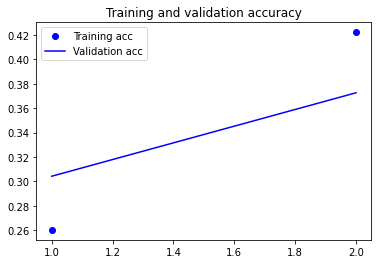

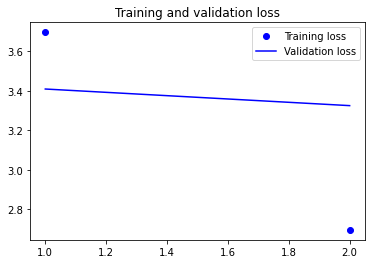

In [ ]:
#plot between training and validation to visualize overfitting
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(X_test,y_test)

90/90 [==============================] - 3s 7ms/step - loss: 3.2201 - accuracy: 0.3836


[3.220078468322754, 0.3836477994918823]

#Testing

In [ ]:
model = keras.models.load_model('/content/drive/My Drive/GeoMind/covid_model.h5', custom_objects=SeqSelfAttention.get_custom_objects())

In [ ]:
test = ["go out and get vaccinated #vaccinated #socialdistancing"]

In [ ]:
vec = tk.texts_to_sequences(test)
padded = pad_sequences(vec, maxlen=40, padding='post')
np_vec = np.array(padded)

In [ ]:
tk.sequences_to_texts(vec)

['go out and get vaccinated UNK #socialdistancing']

In [ ]:
decode_gh(model.predict(np_vec))
#dc

'dqc'

In [ ]:
test2 = ["you can't make me wear a mask"]

In [ ]:
vec = tk.texts_to_sequences(test2)
padded = pad_sequences(vec, maxlen=40, padding='post')
np_vec = np.array(padded)
tk.sequences_to_texts(vec)

["you can't make me wear a mask"]

In [ ]:
decode_gh(model.predict(np_vec))
#florida

'dhv'

In [ ]:
test3 = ["covid is not real! it's a plot from the chinese!"]

In [ ]:
vec = tk.texts_to_sequences(test3)
padded = pad_sequences(vec, maxlen=40, padding='post')
np_vec = np.array(padded)
tk.sequences_to_texts(vec)

["covid is not real it's a plot from the chinese"]

In [ ]:
decode_gh(model.predict(np_vec))
#texas

'9v6'

In [ ]:
test4 = ["make sure to stay at home and wash your hands"]

In [ ]:
vec = tk.texts_to_sequences(test4)
padded = pad_sequences(vec, maxlen=40, padding='post')
np_vec = np.array(padded)
tk.sequences_to_texts(vec)

['make sure to stay at home and wash your hands']

In [ ]:
decode_gh(model.predict(np_vec))
#california

'9q5'